In [1]:
import os
import numpy as np
import pandas as pd
import nltk
import keras
import six
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,AveragePooling1D,Flatten,concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /home/roberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/roberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
#Abro el archivo en el que se encuentra el dataset de los problemas
with open('singleop.json', 'r') as f:
    datastore = json.load(f)

In [4]:
# Archivo que contiene un listado de nombres
nombres = pd.read_csv('nombres-2015.csv')
names = pd.read_csv('yob2019.txt', header=None)    

In [5]:
dataset2 = pd.read_csv('problemas_adicionales2.csv')

In [6]:
preguntas = []
respuestas = []
ecuaciones = []
alineacion = []

for item in datastore:
    preguntas.append(item['sQuestion'])
    respuestas.append(item['lSolutions'])
    ecuaciones.append(item['lEquations'])
    alineacion.append(item['lAlignments'])

In [7]:
# Necesito convertir el dataset en un problema de clasificacion para que la red neuronal pueda identificar
# si estoy tratando de resolver un problema de sumas, restas, multiplicaciones o divisiones.
# Esto va a crear una lista con el tipo de operacion y que va a ser el resultado a inferir.
operaciones = []
sumas =0
restas =0
multiplicaciones =0
divisiones = 0
otras = 0
#Clasifico las operaciones en 0 para sumas, 1 para restas, 2 para multiplicaciones, 3 para divisiones y 4 sino lo encuentro.
for operacion in ecuaciones:
    if (operacion[0].find('+')>=0):
        operaciones.append(0)
        sumas = sumas + 1
    elif (operacion[0].find('-') >= 0 ):
        operaciones.append(1)
        restas = restas + 1
    elif(operacion[0].find('*') >=0):
        operaciones.append(2)
        multiplicaciones = multiplicaciones + 1
    elif(operacion[0].find('/')):
        operaciones.append(3)
        divisiones = divisiones + 1
    else:
        operaciones.append(4)
        otras = otras + 1

print('Tengo ', sumas, ' sumas ', restas, ' restas, ', multiplicaciones, ' multiplicaciones, ', divisiones, ' divisiones y otras operaciones ', otras)

Tengo  159  sumas  162  restas,  117  multiplicaciones,  124  divisiones y otras operaciones  0


In [8]:
preguntas2 = dataset2['Preguntas'].tolist()
respuestas2 = dataset2['respuestas'].tolist()

In [9]:
preguntas3 = preguntas + preguntas2
respuestas3 = operaciones + respuestas2

In [10]:
#El listado de nombres lo voy a truncar a los 15K primeros, dado que el resto son nombres muy residuales.
nombres_ = nombres['nombre'][:15000]

In [11]:
names_= names[0]

In [12]:
nombres_ = nombres_.append(names_)

In [13]:
st_words = list(stop_words)

In [14]:
nom = nombres['nombre'].values.tolist()

In [15]:
nomb =  nom + st_words

In [16]:
nomb[-1]

'estaríamos'

In [17]:
# El vector preguntas_sin, consiste en las preguntas a las que voy a eliminar todos los nombres propios que no
# anaden ningun valor al conjunto de preguntas. No quiero que esos nombres se procesen y por tanto los elimino.
def eliminar_palabras(dataset, stopw):
    preguntas_sin = []
    for palabras in dataset:
        frases = [word for word in palabras.split(' ') if word not in stopw]
        frases = " ".join(frases)
        preguntas_sin.append(frases)
    return preguntas_sin

In [18]:
preguntas_sin = eliminar_palabras(preguntas3, nomb)

In [19]:
from sklearn.utils import shuffle

preguntas3, respuestas3 = shuffle(preguntas_sin,respuestas3)

In [20]:
frases = []
palabra_sola = []
tokenizer = RegexpTokenizer(r'\w+')

for i,pregunta in enumerate(preguntas_sin):
    palabras = tokenizer.tokenize(pregunta)
    preguntas_w = []
    for palabra in palabras:
        preguntas_w.append(palabra)
        palabra_sola.append(palabra)
    frases.append(preguntas_w)

In [21]:
palabras_unicas = set(palabra_sola)

In [22]:
len(palabras_unicas)

2305

In [23]:
p_unicas = list(palabras_unicas)

#Voy a convertir los indices a escala logaritmica para evitar que puedan reventar los pesos en la red neuronal
vocabulario = {p:i for i, p in enumerate(p_unicas)}

In [24]:
tamanoMedio = 0
tamanoTotal = 0

for pregunta in frases:
    if(len(pregunta) > tamanoTotal):
        tamanoTotal = len(pregunta)
    tamanoMedio = tamanoMedio + len(pregunta)

print("El tamano max es ", tamanoTotal, " y la media de la longitud de las frases es de", tamanoMedio/len(frases))

El tamano max es  31  y la media de la longitud de las frases es de 12.803901437371664


In [25]:
# Voy a meter en este vector todas mis preguntas y todas las palabras.
# Para esta prueba, vamos a poner en la posición de la frase, el número de la palabra que estamos procesando.
# El objetivo es procesar las palabras teniendo en cuenta el orden secuencial de la frase.
bag = np.zeros([len(frases), tamanoTotal, len(palabras_unicas)])

In [26]:
bag.shape

(974, 31, 2305)

In [27]:
for i, pregunta in enumerate(frases):
    for j, palabras in enumerate(pregunta):
        bag[i, tamanoTotal - len(pregunta) + j, vocabulario[palabras]] = 1.0

In [28]:
bag[0][0]

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
training_X = np.asarray(bag[:800])
test_X = np.asarray(bag[800:])
training_y = np.asarray(respuestas3[:800])
test_y = np.asarray(respuestas3[800:])


In [50]:
# Creamos un modelo donde el primer argumento de la capa embedding son las palabras totales que voy a procesar
# vectorizadas en un indice.
# El segundo argumento, es el tamano del vector embedding, que he fijado en 16.
# El tercer argumento, es el tamano o longitud maxima, que he definido para las preguntas. Numero total de palabras
# por pregunta.
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(36, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [51]:
history = model.fit(training_X, training_y, epochs = 300, validation_data=(test_X, test_y), batch_size = 128)

Epoch 1/300
7/7 [==============================] - 0s 68ms/step - loss: 1.3809 - accuracy: 0.3613 - val_loss: 1.3741 - val_accuracy: 0.3621
Epoch 2/300
7/7 [==============================] - 0s 65ms/step - loss: 1.3473 - accuracy: 0.3750 - val_loss: 1.3623 - val_accuracy: 0.3621
Epoch 3/300
7/7 [==============================] - 1s 76ms/step - loss: 1.2985 - accuracy: 0.3750 - val_loss: 1.3520 - val_accuracy: 0.3621
Epoch 4/300
7/7 [==============================] - 0s 68ms/step - loss: 1.2233 - accuracy: 0.3787 - val_loss: 1.3495 - val_accuracy: 0.3621
Epoch 5/300
7/7 [==============================] - 0s 65ms/step - loss: 1.1195 - accuracy: 0.3913 - val_loss: 1.3633 - val_accuracy: 0.3621
Epoch 6/300
7/7 [==============================] - 0s 55ms/step - loss: 1.0081 - accuracy: 0.4625 - val_loss: 1.3813 - val_accuracy: 0.3621
Epoch 7/300
7/7 [==============================] - 0s 62ms/step - loss: 0.8674 - accuracy: 0.6825 - val_loss: 1.3963 - val_accuracy: 0.3448
Epoch 8/300
7/7 [===

7/7 [==============================] - 0s 58ms/step - loss: 0.0564 - accuracy: 0.9700 - val_loss: 2.3732 - val_accuracy: 0.3161
Epoch 60/300
7/7 [==============================] - 0s 63ms/step - loss: 0.0457 - accuracy: 0.9750 - val_loss: 2.3670 - val_accuracy: 0.3103
Epoch 61/300
7/7 [==============================] - 0s 61ms/step - loss: 0.0441 - accuracy: 0.9750 - val_loss: 2.3676 - val_accuracy: 0.3161
Epoch 62/300
7/7 [==============================] - 0s 52ms/step - loss: 0.0431 - accuracy: 0.9737 - val_loss: 2.4111 - val_accuracy: 0.3103
Epoch 63/300
7/7 [==============================] - 0s 50ms/step - loss: 0.0568 - accuracy: 0.9737 - val_loss: 2.4137 - val_accuracy: 0.3103
Epoch 64/300
7/7 [==============================] - 0s 67ms/step - loss: 0.0508 - accuracy: 0.9775 - val_loss: 2.4490 - val_accuracy: 0.3046
Epoch 65/300
7/7 [==============================] - 0s 59ms/step - loss: 0.0433 - accuracy: 0.9787 - val_loss: 2.4347 - val_accuracy: 0.2931
Epoch 66/300
7/7 [========

7/7 [==============================] - 0s 54ms/step - loss: 0.0459 - accuracy: 0.9750 - val_loss: 2.6197 - val_accuracy: 0.3161
Epoch 118/300
7/7 [==============================] - 0s 57ms/step - loss: 0.0449 - accuracy: 0.9737 - val_loss: 2.6213 - val_accuracy: 0.3161
Epoch 119/300
7/7 [==============================] - 0s 57ms/step - loss: 0.0402 - accuracy: 0.9787 - val_loss: 2.6115 - val_accuracy: 0.3103
Epoch 120/300
7/7 [==============================] - 0s 56ms/step - loss: 0.0462 - accuracy: 0.9725 - val_loss: 2.6293 - val_accuracy: 0.3046
Epoch 121/300
7/7 [==============================] - 0s 52ms/step - loss: 0.0414 - accuracy: 0.9750 - val_loss: 2.6064 - val_accuracy: 0.3161
Epoch 122/300
7/7 [==============================] - 0s 53ms/step - loss: 0.0428 - accuracy: 0.9737 - val_loss: 2.6158 - val_accuracy: 0.3103
Epoch 123/300
7/7 [==============================] - 0s 54ms/step - loss: 0.0482 - accuracy: 0.9688 - val_loss: 2.6032 - val_accuracy: 0.3161
Epoch 124/300
7/7 [=

Epoch 175/300
7/7 [==============================] - 0s 50ms/step - loss: 0.0420 - accuracy: 0.9737 - val_loss: 2.7446 - val_accuracy: 0.3103
Epoch 176/300
7/7 [==============================] - 0s 52ms/step - loss: 0.0410 - accuracy: 0.9775 - val_loss: 2.7643 - val_accuracy: 0.3046
Epoch 177/300
7/7 [==============================] - 0s 52ms/step - loss: 0.0452 - accuracy: 0.9725 - val_loss: 2.7697 - val_accuracy: 0.3161
Epoch 178/300
7/7 [==============================] - 0s 61ms/step - loss: 0.0412 - accuracy: 0.9725 - val_loss: 2.7920 - val_accuracy: 0.3046
Epoch 179/300
7/7 [==============================] - 0s 61ms/step - loss: 0.0392 - accuracy: 0.9787 - val_loss: 2.8029 - val_accuracy: 0.3103
Epoch 180/300
7/7 [==============================] - 1s 74ms/step - loss: 0.0409 - accuracy: 0.9787 - val_loss: 2.8024 - val_accuracy: 0.3046
Epoch 181/300
7/7 [==============================] - 1s 73ms/step - loss: 0.0450 - accuracy: 0.9712 - val_loss: 2.8067 - val_accuracy: 0.2989
Epoch 

Epoch 233/300
7/7 [==============================] - 0s 55ms/step - loss: 0.0386 - accuracy: 0.9762 - val_loss: 2.9355 - val_accuracy: 0.3046
Epoch 234/300
7/7 [==============================] - 0s 53ms/step - loss: 0.0391 - accuracy: 0.9775 - val_loss: 2.9534 - val_accuracy: 0.2989
Epoch 235/300
7/7 [==============================] - 0s 52ms/step - loss: 0.0422 - accuracy: 0.9762 - val_loss: 2.9600 - val_accuracy: 0.3046
Epoch 236/300
7/7 [==============================] - 0s 55ms/step - loss: 0.0434 - accuracy: 0.9650 - val_loss: 2.9779 - val_accuracy: 0.3046
Epoch 237/300
7/7 [==============================] - 0s 53ms/step - loss: 0.0409 - accuracy: 0.9750 - val_loss: 3.0047 - val_accuracy: 0.2989
Epoch 238/300
7/7 [==============================] - 0s 66ms/step - loss: 0.0413 - accuracy: 0.9737 - val_loss: 3.0121 - val_accuracy: 0.2989
Epoch 239/300
7/7 [==============================] - 0s 57ms/step - loss: 0.0416 - accuracy: 0.9737 - val_loss: 2.9937 - val_accuracy: 0.2931
Epoch 

Epoch 291/300
7/7 [==============================] - 0s 63ms/step - loss: 0.0401 - accuracy: 0.9750 - val_loss: 3.0219 - val_accuracy: 0.3218
Epoch 292/300
7/7 [==============================] - 0s 63ms/step - loss: 0.0449 - accuracy: 0.9688 - val_loss: 3.0314 - val_accuracy: 0.3218
Epoch 293/300
7/7 [==============================] - 0s 54ms/step - loss: 0.0403 - accuracy: 0.9712 - val_loss: 3.0405 - val_accuracy: 0.3218
Epoch 294/300
7/7 [==============================] - 0s 55ms/step - loss: 0.0401 - accuracy: 0.9737 - val_loss: 3.0467 - val_accuracy: 0.3218
Epoch 295/300
7/7 [==============================] - 0s 48ms/step - loss: 0.0428 - accuracy: 0.9725 - val_loss: 3.0562 - val_accuracy: 0.3218
Epoch 296/300
7/7 [==============================] - 0s 47ms/step - loss: 0.0370 - accuracy: 0.9800 - val_loss: 3.0701 - val_accuracy: 0.3218
Epoch 297/300
7/7 [==============================] - 0s 51ms/step - loss: 0.0412 - accuracy: 0.9725 - val_loss: 3.0922 - val_accuracy: 0.3161
Epoch 

In [52]:
import matplotlib.pyplot as plt

def resultados(history):
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

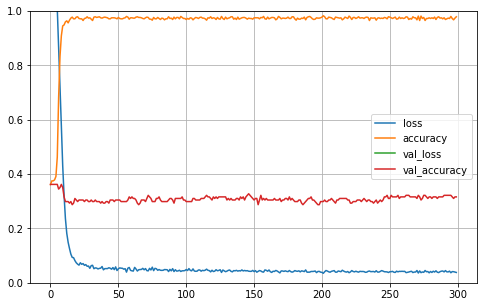

In [53]:
resultados(history)

In [54]:
model2 = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(128, dropout = 0.2, input_shape=[len(vocabulario), bag.shape[1], bag.shape[2]])),
    keras.layers.Dense(4, activation='softmax')
])
#opt = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)

#opt = keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
opt = keras.optimizers.Adam(learning_rate = 0.0001)
model2.compile(loss='sparse_categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [46]:
training_X.shape

(800, 31, 2305)

In [55]:
history2 = model2.fit(training_X, training_y, epochs = 240, batch_size= 128, validation_data=(test_X, test_y))

Epoch 1/240
7/7 [==============================] - 6s 919ms/step - loss: 1.3862 - accuracy: 0.2725 - val_loss: 1.3825 - val_accuracy: 0.3333
Epoch 2/240
7/7 [==============================] - 6s 808ms/step - loss: 1.3827 - accuracy: 0.3487 - val_loss: 1.3803 - val_accuracy: 0.3736
Epoch 3/240
7/7 [==============================] - 6s 810ms/step - loss: 1.3791 - accuracy: 0.3738 - val_loss: 1.3779 - val_accuracy: 0.3621
Epoch 4/240
7/7 [==============================] - 5s 763ms/step - loss: 1.3753 - accuracy: 0.3812 - val_loss: 1.3751 - val_accuracy: 0.3621
Epoch 5/240
7/7 [==============================] - 6s 805ms/step - loss: 1.3710 - accuracy: 0.3762 - val_loss: 1.3717 - val_accuracy: 0.3621
Epoch 6/240
7/7 [==============================] - 5s 760ms/step - loss: 1.3658 - accuracy: 0.3750 - val_loss: 1.3675 - val_accuracy: 0.3621
Epoch 7/240
7/7 [==============================] - 6s 903ms/step - loss: 1.3590 - accuracy: 0.3750 - val_loss: 1.3620 - val_accuracy: 0.3621
Epoch 8/240
7

Epoch 59/240
7/7 [==============================] - 6s 903ms/step - loss: 0.3415 - accuracy: 0.8600 - val_loss: 3.0866 - val_accuracy: 0.3046
Epoch 60/240
7/7 [==============================] - 7s 961ms/step - loss: 0.3441 - accuracy: 0.8700 - val_loss: 3.0847 - val_accuracy: 0.3103
Epoch 61/240
7/7 [==============================] - 7s 935ms/step - loss: 0.3738 - accuracy: 0.8525 - val_loss: 2.9832 - val_accuracy: 0.3046
Epoch 62/240
7/7 [==============================] - 6s 852ms/step - loss: 0.3356 - accuracy: 0.8913 - val_loss: 2.8795 - val_accuracy: 0.2874
Epoch 63/240
7/7 [==============================] - 6s 864ms/step - loss: 0.3277 - accuracy: 0.8712 - val_loss: 2.9424 - val_accuracy: 0.2931
Epoch 64/240
7/7 [==============================] - 6s 924ms/step - loss: 0.3404 - accuracy: 0.8763 - val_loss: 2.8990 - val_accuracy: 0.2931
Epoch 65/240
7/7 [==============================] - 7s 961ms/step - loss: 0.3006 - accuracy: 0.9025 - val_loss: 3.0537 - val_accuracy: 0.2931
Epoch 

Epoch 117/240
7/7 [==============================] - 7s 982ms/step - loss: 0.2032 - accuracy: 0.9275 - val_loss: 3.5651 - val_accuracy: 0.2701
Epoch 118/240
7/7 [==============================] - 7s 996ms/step - loss: 0.2450 - accuracy: 0.9075 - val_loss: 3.6012 - val_accuracy: 0.2931
Epoch 119/240
7/7 [==============================] - 7s 1s/step - loss: 0.2046 - accuracy: 0.9300 - val_loss: 3.7780 - val_accuracy: 0.2759
Epoch 120/240
7/7 [==============================] - 7s 1s/step - loss: 0.1867 - accuracy: 0.9362 - val_loss: 3.6750 - val_accuracy: 0.2931
Epoch 121/240
7/7 [==============================] - 9s 1s/step - loss: 0.2003 - accuracy: 0.9250 - val_loss: 3.7499 - val_accuracy: 0.2759
Epoch 122/240
7/7 [==============================] - 7s 1s/step - loss: 0.1771 - accuracy: 0.9425 - val_loss: 3.7924 - val_accuracy: 0.2644
Epoch 123/240
7/7 [==============================] - 6s 896ms/step - loss: 0.1757 - accuracy: 0.9413 - val_loss: 3.8950 - val_accuracy: 0.2586
Epoch 124/2

7/7 [==============================] - 6s 834ms/step - loss: 0.1940 - accuracy: 0.9325 - val_loss: 4.0654 - val_accuracy: 0.2759
Epoch 175/240
7/7 [==============================] - 6s 892ms/step - loss: 0.1641 - accuracy: 0.9362 - val_loss: 3.9668 - val_accuracy: 0.2644
Epoch 176/240
7/7 [==============================] - 6s 812ms/step - loss: 0.1882 - accuracy: 0.9300 - val_loss: 4.0568 - val_accuracy: 0.2586
Epoch 177/240
7/7 [==============================] - 7s 949ms/step - loss: 0.1774 - accuracy: 0.9262 - val_loss: 3.9795 - val_accuracy: 0.2701
Epoch 178/240
7/7 [==============================] - 6s 811ms/step - loss: 0.1578 - accuracy: 0.9400 - val_loss: 4.1491 - val_accuracy: 0.2644
Epoch 179/240
7/7 [==============================] - 6s 799ms/step - loss: 0.1689 - accuracy: 0.9375 - val_loss: 4.1262 - val_accuracy: 0.2816
Epoch 180/240
7/7 [==============================] - 8s 1s/step - loss: 0.1765 - accuracy: 0.9337 - val_loss: 4.1152 - val_accuracy: 0.2586
Epoch 181/240
7/

7/7 [==============================] - 6s 816ms/step - loss: 0.1644 - accuracy: 0.9312 - val_loss: 4.3062 - val_accuracy: 0.2586
Epoch 232/240
7/7 [==============================] - 6s 861ms/step - loss: 0.1344 - accuracy: 0.9450 - val_loss: 4.3759 - val_accuracy: 0.2644
Epoch 233/240
7/7 [==============================] - 6s 837ms/step - loss: 0.1297 - accuracy: 0.9525 - val_loss: 4.4518 - val_accuracy: 0.2644
Epoch 234/240
7/7 [==============================] - 9s 1s/step - loss: 0.1182 - accuracy: 0.9588 - val_loss: 4.4655 - val_accuracy: 0.2644
Epoch 235/240
7/7 [==============================] - 8s 1s/step - loss: 0.1700 - accuracy: 0.9287 - val_loss: 4.4066 - val_accuracy: 0.2586
Epoch 236/240
7/7 [==============================] - 9s 1s/step - loss: 0.1533 - accuracy: 0.9438 - val_loss: 4.2205 - val_accuracy: 0.2644
Epoch 237/240
7/7 [==============================] - 6s 861ms/step - loss: 0.1365 - accuracy: 0.9513 - val_loss: 4.2798 - val_accuracy: 0.2644
Epoch 238/240
7/7 [===

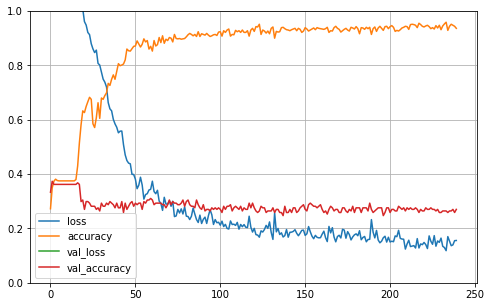

In [56]:
resultados(history2)